In [125]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
import time
import xgboost as xgb
import joblib
import os
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

Читаем данные

In [67]:
df = pd.read_csv(r"data\train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Проверим на пропущенные значения по heatmap

<Axes: >

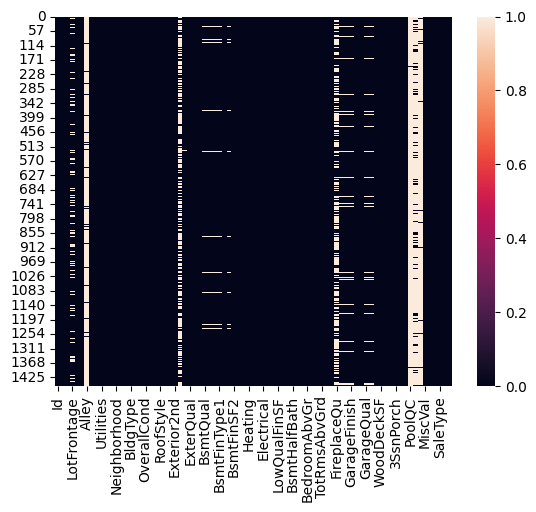

In [68]:
sns.heatmap(df.isnull())

Есть несколько столбцов в которых очень много пропущенных значений, удалим их

Избавляемся от столбцов в которых число пропущенных значений больше 10%

In [69]:
num_str = df.shape[0]
sum_null_in_cols = df.isnull().sum()
missing_cols = sum_null_in_cols[sum_null_in_cols > num_str * 0.1]
df = df.drop(columns=missing_cols.index.tolist())
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Разделим данные на признаки и целевую переменную

In [70]:
target = np.log1p(df["SalePrice"])
feature = df.drop(columns=['Id', 'SalePrice'])

Заполним оставшиеся пропуски

In [71]:
num_features = feature.select_dtypes(exclude=['object']).columns.tolist()
cat_features = feature.select_dtypes(include=['object']).columns.tolist()

imputer_num = KNNImputer(n_neighbors = 5, weights = "distance")
imputer_cat = SimpleImputer(strategy="most_frequent")

feature[num_features] = imputer_num.fit_transform(feature[num_features])
feature[cat_features] = imputer_cat.fit_transform(feature[cat_features])

print(f"Пропущенных значений: {feature.isnull().sum().sum()}")



Пропущенных значений: 0


Убедимся снова построив heatmap

<Axes: >

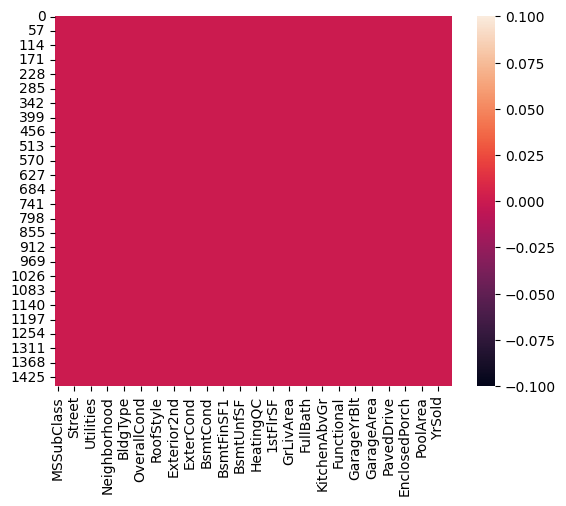

In [72]:
sns.heatmap(feature.isnull())

Отлично, теперь преобразуем признаки в числовые переменные, для этого используем Ordinal, Label, One-Hot encoders<br>
Их подбор производился GPT

In [73]:
feature = pd.get_dummies(feature, columns=['MSZoning', 'Street', 'LotConfig', 'BldgType', 'HouseStyle', 
                                 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 
                                 'PavedDrive', 'SaleType', 'SaleCondition', 'Utilities'], drop_first=True)

ordinal_cols = [
    'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 
    'Functional', 'LandContour', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond'
]

ordinal_mapping = [
    ['Reg', 'IR1', 'IR2', 'IR3'], 
    ['Gtl', 'Mod', 'Sev'], 
    ['Ex', 'Gd', 'TA', 'Fa'], 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    ['Ex', 'Gd', 'TA', 'Fa'], 
    ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev'],
    ['Bnk', 'Lvl', 'HLS', 'Low'],
    ['Ex', 'Gd', 'TA', 'Fa'],  
    ['TA', 'Gd', 'Fa', 'Po'], 
    ['No', 'Gd', 'Mn', 'Av'],  
    ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'],  
    ['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ'], 
    ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],  
    ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment', '2Types'],  
    ['RFn', 'Unf', 'Fin'],  
    ['TA', 'Fa', 'Gd', 'Ex', 'Po'], 
    ['TA', 'Fa', 'Gd', 'Po', 'Ex']  
]

encoder = OrdinalEncoder(categories=ordinal_mapping)

feature[ordinal_cols] = encoder.fit_transform(feature[ordinal_cols])

label_cols = ['Neighborhood', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
le = LabelEncoder()

for col in label_cols:
    feature[col] = le.fit_transform(feature[col])


cat_features = feature.select_dtypes(include=['object']).columns.tolist()
print(f"Количество признаков не переведенных в числовые: {len(cat_features)}")

if len(cat_features) > 0:
    for col in feature.columns:
        if feature[col].dtype not in ["float64", "int64", "bool"]:
            print(f"Col: {col}, dtype: {feature[col].dtype}, unique: {feature[col].unique()}")

Количество признаков не переведенных в числовые: 0


In [74]:
feature.head()

,MSSubClass,LotArea,LotShape,LandContour,LandSlope,Neighborhood,Condition1,Condition2,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Utilities_NoSeWa
0,60.0,8450.0,0.0,1.0,0.0,5,2,2,7.0,5.0,...,False,False,False,True,False,False,False,True,False,False
1,20.0,9600.0,0.0,1.0,0.0,24,1,2,6.0,8.0,...,False,False,False,True,False,False,False,True,False,False
2,60.0,11250.0,1.0,1.0,0.0,5,2,2,7.0,5.0,...,False,False,False,True,False,False,False,True,False,False
3,70.0,9550.0,1.0,1.0,0.0,6,2,2,7.0,5.0,...,False,False,False,True,False,False,False,False,False,False
4,60.0,14260.0,1.0,1.0,0.0,15,2,2,8.0,5.0,...,False,False,False,True,False,False,False,True,False,False


Переходим к постраению модели

In [75]:
X_train, x_vt, Y_train, y_vt = train_test_split(feature, target, test_size= 0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(x_vt, y_vt, test_size=0.5, random_state=42)
Y_test = np.expm1(Y_test)


In [76]:
def RMSE(model, select_col = X_train.columns):
    predicted = np.expm1(model.predict(X_test[select_col]))

    loss = root_mean_squared_error(predicted, Y_test)

    print(loss)

    return loss

def simplest_model(select_col = X_train.columns, title = ""):
    start = time.time()

    if title:
        print(title, '\n')

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train[select_col], Y_train)

    RMSE(model, select_col)

    end = time.time()
    print(f"time: {end - start}", '\n')

    return model



In [77]:
model = simplest_model()

21309.67629544712
time: 3.287703514099121 



In [78]:
coef = model.feature_importances_ * 100

table_coef = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Persentage importance': coef
})

# for i in range(12):
#     print(table_coef[i * 10: (i + 1) * 10])

Теперь отсеим лишние признаки.

In [79]:
feature_more_05_per_importance = table_coef[table_coef["Persentage importance"] > 0.5]["Feature"].tolist()
feature_more_01_per_importance = table_coef[table_coef["Persentage importance"] > 0.1]["Feature"].tolist()
print(feature_more_05_per_importance, '\n')
print(feature_more_01_per_importance)

['LotArea', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtQual', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'OpenPorchSF', 'MSZoning_RM', 'CentralAir_Y'] 

['MSSubClass', 'LotArea', 'LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'Condition1', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'MSZoning_RL', 'MSZoning_RM', 'Heating_Grav', 'CentralAir

Посмотрим как будет теперь работать модель

In [80]:
simplest_model(select_col = feature_more_05_per_importance, title="feature_more_05_per_importance")
simplest_model(select_col = feature_more_01_per_importance, title="feature_more_01_per_importance")

feature_more_05_per_importance 

20544.871010607334
time: 1.7001910209655762 

feature_more_01_per_importance 

20966.189256143134
time: 2.676957845687866 



RandomForestRegressor(random_state=42)

In [113]:
best_feature_RF = feature_more_05_per_importance

почему-то xgb не работает с bool, поэтому преобразуем их в int32


In [82]:
X_train_ = X_train.astype({col: "int32" for col in X_train.select_dtypes(include="bool").columns})
X_test_ = X_test.astype({col: "int32" for col in X_test.select_dtypes(include="bool").columns})

Стало лучше! Теперь создадим вторую модель, чтобы потом их объединить, создадим xgb model

In [83]:
def XGBoost_model_simplest(select_col = X_train_.columns, title = ""):
    start = time.time()

    if title:
        print(title, '\n')

    model = xgb.XGBRegressor(
        objective="reg:squarederror",  
        n_estimators=500,              
        learning_rate=0.05,           
        max_depth=6,                  
        subsample=0.8,                
        colsample_bytree=0.8,          
        random_state=42
        )

    model.fit(X_train_[select_col], Y_train)

    predicted = np.expm1(model.predict(X_test_[select_col]))

    loss = root_mean_squared_error(predicted, Y_test)

    print(f"RMSE: {loss}")

    end = time.time()
    print(f"time: {end - start}", '\n')

    return model

In [84]:
model_xgb = XGBoost_model_simplest()

RMSE: 19150.785817747597
time: 2.9327914714813232 



In [85]:
coef = model_xgb.feature_importances_ * 100

table_coef = pd.DataFrame({
    'Feature': X_train.columns.tolist(),
    'Persentage importance': coef
})

In [86]:
feature_more_1_per_imp = table_coef[table_coef["Persentage importance"] > 1]["Feature"].tolist()
feature_more_05_per_imp = table_coef[table_coef["Persentage importance"] > 0.5]["Feature"].tolist()
feature_more_005_per_imp = table_coef[table_coef["Persentage importance"] > 0.05]["Feature"].tolist()
print(feature_more_1_per_imp)
print(feature_more_05_per_imp)
print(feature_more_005_per_imp)

['OverallQual', 'ExterQual', 'BsmtQual', 'GrLivArea', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'MSZoning_RL', 'MSZoning_RM', 'CentralAir_Y']
['LandContour', 'Condition2', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'GarageCars', 'GarageArea', 'MSZoning_RL', 'MSZoning_RM', 'CentralAir_Y', 'SaleCondition_Partial']
['MSSubClass', 'LotArea', 'LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Be

In [87]:
XGBoost_model_simplest(select_col= feature_more_1_per_imp, title= "feature_more_1_per_imp")
XGBoost_model_simplest(select_col= feature_more_05_per_imp, title= "feature_more_05_per_imp")
XGBoost_model_simplest(select_col= feature_more_005_per_imp, title= "feature_more_005_per_imp")

feature_more_1_per_imp 

RMSE: 26551.4629151611
time: 1.2883954048156738 

feature_more_05_per_imp 

RMSE: 21555.145762686072
time: 1.5103704929351807 

feature_more_005_per_imp 

RMSE: 19283.304404505965
time: 2.4897875785827637 



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

С увеличением количества признаков, модель становиться только лучше, попробуем еще уменьшить

In [88]:
print(len(feature.columns))
print(len(feature_more_005_per_imp))

feature_more_0001_per_imp = table_coef[table_coef["Persentage importance"] > 0.001]["Feature"].tolist()
XGBoost_model_simplest(select_col= feature_more_0001_per_imp, title= "feature_more_0001_per_imp")

print(len(feature_more_0001_per_imp))

117
82
feature_more_0001_per_imp 

RMSE: 18757.640794003433
time: 2.871202230453491 

97


Поэксперементировав, я получил наилучший результат при 1 тысячной процента

In [89]:
best_feature_XGB = feature_more_0001_per_imp

Обучим последнюю модель KNN, перед объединением, для начала отберем признаки.

In [90]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.05))
])

pipe.fit(X_train, Y_train)

coef = pipe.named_steps["model"].coef_
select_feature_lasso = X_train.columns[coef != 0]
print(select_feature_lasso)

Index(['OverallQual', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'KitchenQual', 'Fireplaces', 'GarageCars',
       'MSZoning_RM', 'CentralAir_Y'],
      dtype='object')


In [91]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=mutual_info_regression, k=10))
])

pipe.fit(X_train, Y_train)

coef = pipe.named_steps["selector"].get_support()
select_feature_SelKBest = X_train.columns[coef != 0]
print(select_feature_SelKBest)

Index(['Neighborhood', 'OverallQual', 'YearBuilt', 'BsmtQual', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'KitchenQual', 'GarageCars', 'GarageArea'],
      dtype='object')


In [109]:
best_feature_KNN = list(set(select_feature_lasso).intersection(set(select_feature_SelKBest)))

print(f"Выбраны признаки: {best_feature_KNN}")

Выбраны признаки: ['GrLivArea', 'KitchenQual', 'TotalBsmtSF', 'GarageCars', 'BsmtQual', '1stFlrSF', 'OverallQual']


In [110]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}

best_score = float('inf')
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    model = KNeighborsRegressor(**params)
    model.fit(X_val[best_feature_KNN], Y_val)  
    preds = np.expm1(model.predict(X_val[best_feature_KNN])) 
    rmse = root_mean_squared_error(Y_val, preds)

    if rmse < best_score:
        best_score = rmse
        best_params = params
        best_model = model

print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


In [111]:
model_KNN = KNeighborsRegressor(**best_params)
model_KNN.fit(X_train[best_feature_KNN], Y_train)
predicted = np.expm1(model_KNN.predict(X_test[best_feature_KNN]))
rmse = root_mean_squared_error(Y_test, predicted)
print(rmse)

37971.34159276819


Осталось дело за малым, для начала подберем гиперпараметры для RandomForest и XGBoost, получим итоговые модели и объединим их.

In [101]:
def general_RF(save_model = 0, title = "", selected_cols = X_train.columns):
    start = time.time()

    if title:
        print(title)

    param_grid_RF = {
        'n_estimators': [40, 100, 300, 550, 1000],
        'max_depth': [7, 9, 11],
        'min_samples_split': [2, 3, 4, 6]
    }

    model_RF = RandomForestRegressor()

    grid_search_RF = GridSearchCV(model_RF, param_grid = param_grid_RF, cv = 4, scoring = "neg_root_mean_squared_error", n_jobs = -1)

    grid_search_RF.fit(X_val[selected_cols], Y_val) #обучаем на валидационной выборке для подбора гиперпараметров

    best_param = grid_search_RF.best_params_

    print("Best params:", best_param)

    model_RF = RandomForestRegressor(**best_param) #теперь обучаем основную модель

    model_RF.fit(X_train[selected_cols], Y_train)

    rmse = RMSE(model_RF, select_col= selected_cols)

    # save_model = 0 - модель не сохраняется
    # save_model = 1 - модель сохраняется в любос случае
    # save_model = 2 - модель сохраняется только если модель дает лучшие результаты
    if save_model:
        if save_model == 2: 
            try: #используем try если будет ошибка, например до этого не было сохраненной модели или были другие 
                #признаки в обучении, если срабатывает, то модель сохраняется, даже если не лучше
                model_RF_ = joblib.load("model\model_RF_general_file2")
                rmse_ = RMSE(model_RF_, select_col= selected_cols)
                if rmse < rmse_:
                    joblib.dump(model_RF, "model\model_RF_general_file2")
            except:
                joblib.dump(model_RF, "model\model_RF_general_file2")
        else: # если подавалась единица 
            joblib.dump(model_RF, "model\model_RF_general_file2")
    
    end = time.time()

    print(f"time: {end - start}")

    return model_RF



In [ ]:
model_RF = general_RF(save_model=2, title = "general_model_RF", selected_cols = best_feature_RF)

general_model_RF
Best params: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 1000}
20799.35932844643
21736.82872368113
time: 149.43923473358154


In [99]:
def general_XGB(save_model=0, title="", selected_cols=X_train.columns):
    start = time.time()

    if title:
        print(title)

    # Параметры для подбора
    param_grid_XGB = {
        'n_estimators': [100, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1]
    }

    model_XGB = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )

    grid_search_XGB = GridSearchCV(
        model_XGB,
        param_grid=param_grid_XGB,
        cv=4,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    grid_search_XGB.fit(X_val[selected_cols], Y_val)

    best_param = grid_search_XGB.best_params_

    print("Best params:", best_param)

    model_XGB = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        verbosity=0,
        random_state=42,
        **best_param
    )

    model_XGB.fit(X_train[selected_cols], Y_train)

    rmse = RMSE(model_XGB, select_col=selected_cols)

    if save_model:
        if save_model == 2:
            try:
                model_XGB_ = joblib.load("model/model_XGB_general_file2")
                rmse_ = RMSE(model_XGB_, select_col=selected_cols)
                if rmse < rmse_:
                    joblib.dump(model_XGB, "model/model_XGB_general_file2")
            except:
                joblib.dump(model_XGB, "model/model_XGB_general_file2")
        else:
            joblib.dump(model_XGB, "model/model_XGB_general_file2")

    end = time.time()

    print(f"time: {end - start:.2f} sec")

    return model_XGB

In [100]:
model_XGB = general_XGB(save_model=2, title="general model XGB", selected_cols= best_feature_XGB)

general model XGB
Best params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
18696.912875000147
time: 93.04 sec


In [123]:
predicted_XGB = np.expm1(model_XGB.predict(X_test[best_feature_XGB]))
predicted_RF = np.expm1(model_RF.predict(X_test[best_feature_RF]))
predicted_KNN = np.expm1(model_KNN.predict(X_test[best_feature_KNN]))

final_predict = predicted_XGB * 0.6 + predicted_RF * 0.3 + predicted_KNN * 0.1

rmse = root_mean_squared_error(final_predict, Y_test)

print(rmse)

18733.06374968769


In [130]:
model_KNN.fit(X_train, Y_train)
model_RF.fit(X_train, Y_train)
model_XGB.fit(X_train, Y_train)

pred_knn = model_KNN.predict(X_val)
pred_rf = model_RF.predict(X_val)
pred_xgb = model_XGB.predict(X_val)

stacked_features = np.column_stack((pred_knn, pred_rf, pred_xgb))

meta_model = LinearRegression()
meta_model.fit(stacked_features, Y_val)

test_pred_knn = model_KNN.predict(X_test)
test_pred_rf = model_RF.predict(X_test)
test_pred_xgb = model_XGB.predict(X_test)

test_stacked = np.column_stack((test_pred_knn, test_pred_rf, test_pred_xgb))
final_pred = np.expm1(meta_model.predict(test_stacked))

rmse = root_mean_squared_error(final_pred, Y_test)

print(rmse)

19207.75856170388


перенесу в отдельный файл где будет только необходимое без исследований